In [1]:
using LinearAlgebra
using SparseArrays

using Plots
using LaTeXStrings

# TODO
1. Include variable dielectric constant 


# Auxiliary functions
Functions for creating boundary conditions and imposing voltages on straight line-pieces (e.g. to mimick conductors at a fixed potential)

In [2]:
function bnd_dirichlet(A, f, a, boundary, interior)
    Nbnd = length(boundary);
    Nint = length(interior);
    A[boundary,interior] = zeros(Nbnd, Nint); 
    A[boundary,boundary] = Diagonal(ones(Nbnd)); 
    f[boundary] = a * ones(Nbnd); 
    
    return A, f;
end

function get_idx(x, y, Nx, Ny)
    i = unique(trunc.(Int, x * Nx) .+ 1);
    j = unique(trunc.(Int, y * Ny) .+ 1);
    return i, j;
end

function get_line_x(x, ymin, ymax, Nx, Ny)
    y_set   = collect(ymin : (ymax - ymin) / Ny : ymax);
    x_set   = x * ones(length(y_set));
    
    CI      = zeros(Nx+1, Ny+1);
    j,i     = get_idx(x_set, y_set, Nx, Ny);
    CI[i,j] = ones(length(i) * length(j));
    CIvec   = reshape(CI, (Nx+1)*(Ny+1), 1);
    
    idx     = findall(x->x==1,CIvec); idx = L[idx];
    return idx;
end

function get_line_y(xmin, xmax, y, Nx, Ny)
    x_set   = collect(xmin : (xmax - xmin) / Nx : xmax);
    y_set   = y * ones(length(x_set));
    
    CI      = zeros(Nx+1, Ny+1);
    j,i     = get_idx(x_set, y_set, Nx, Ny);
    CI[i,j] = ones(length(i) * length(j));
    CIvec   = reshape(CI, (Nx+1)*(Ny+1), 1);
    
    idx     = findall(x->x==1,CIvec); idx = L[idx];
    return idx;
end

get_line_y (generic function with 1 method)

# Example 1: Parallel-Plate Capacitor in Air

In [3]:
Nx = 200;
Ny = 200;

#..compute derived numbers such as 
#..the points on the boundary (Nbnd) and the mesh width (h)
Nxp1 = Nx+1; Nxm1 = Nx-1; hx = 1/Nx; hx2 = hx*hx;
Nyp1 = Ny+1; Nym1 = Ny-1; hy = 1/Ny; hy2 = hy*hy;
Nbnd = 2*(Nx+Ny);

# Construct the 2D mesh
x  = Vector(0:hx:1);
y  = Vector(0:hy:1);
Xh = collect(tuple(c,1-r) for r in x, c in y);

# Construct the vector fh from the source term
#sourceterm((x,y)) = 0;
#F = sourceterm.(Xh);
f = zeros(Nxp1 * Nyp1);#reshape(F, Nxp1*Nyp1);

#..construct the mesh indicator matrix IG 
#..this indicator matrix will allow to distinguish interior and boundary nodes 
#..in this indicator matrix the boundary nodes are easy to identify 
#..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
#..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
IG = ones(Nxp1,Nyp1);
IG[2:end-1,2:end-1] = zeros(Nxm1,Nym1); 
IGvec = reshape(IG,Nxp1*Nyp1,1); 

#..construct array with linear indices allowing to define interior and boundary nodes 
#..interior: index array with all indices of the interior nodes 
#..boundary: index array with indices of all the boundary nodes 
L = LinearIndices(IGvec); 
interior_cartesian = findall(x->x==0,IGvec); interior = L[interior_cartesian]; 
boundary_cartesian = findall(x->x==1,IGvec); boundary = L[boundary_cartesian]; 

#..construct auxiliary vectors used in the 1D code as well 
ex    = ones(Nxp1);            #..same as in 1D.. 
ey    = ones(Nyp1);            #..same as in 1D.. 
e_bnd = ones(length(boundary)); #..used to handle the boundary nodes 

#..Construct one-dimensional matrix
Ax1 = 1/hx2 * sparse(Tridiagonal(-ex[2:end], 2*ex, -ex[2:end])); 
Ay1 = 1/hy2 * sparse(Tridiagonal(-ey[2:end], 2*ey, -ey[2:end])); 
Ix_int = Diagonal(ex); 
Iy_int = Diagonal(ey); 
I_bnd = Diagonal(e_bnd); 

# Construct single derivative for post-processing
Bx1 = 1/(2*hx) * sparse(Tridiagonal(ex[2:end], 0*ex, -ex[2:end]))
By1 = 1/(2*hy) * sparse(Tridiagonal(ey[2:end], 0*ey, -ey[2:end]))

Bx = kron(Bx1, Iy_int);
By = kron(Ix_int, By1);

#..Construct the 2D matrix using Kronecker products 
Axx = kron(Iy_int, Ax1);
Ayy = kron(Ay1, Ix_int);
A = Axx + Ayy;

#..Handle the boundary conditions in the matrix and the right-hand side vector
A, f = bnd_dirichlet(A, f, 0, boundary, interior);
A, f = bnd_dirichlet(A, f, 1, get_line_y(0.3, 0.7, 0.4, Nx, Ny), interior)
A, f = bnd_dirichlet(A, f, -1, get_line_y(0.3, 0.7, 0.6, Nx, Ny), interior)

#..solve the linear system for the finite difference approximation 
u = A \ f;
U = reshape(u,Nxp1,Nyp1); 

# Post-processing
ux = Bx * u;
uy = By * u;

Ux = reshape(ux, Nxp1, Nyp1);
Uy = reshape(uy, Nxp1, Nyp1);

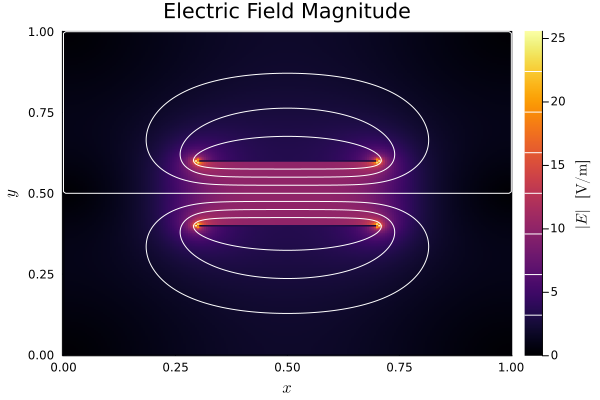

In [4]:
E = sqrt.(Ux.^2 + Uy.^2)
p1 = heatmap(x, y, E, xlabel = L"x", ylabel = L"y", title = "Electric Field Magnitude", colorbar_title = L"|E|\ \ \mathrm{[V/m]}")

# Create contour such that it scales nicely with the colorbar
# Otherwise it will be partially invisible
cntr = maximum(E) * (0.5 * (U / maximum(U)) .+ 0.5)
p1 = contour!(x, y, cntr, color = :white, levels = 7)

# Example 2: Corner Configuration
Well-known high-voltage configuration. Field is zero in the corner, and enhanced at the point.

In [5]:
Nx = 200;
Ny = 200;

#..compute derived numbers such as 
#..the points on the boundary (Nbnd) and the mesh width (h)
Nxp1 = Nx+1; Nxm1 = Nx-1; hx = 1/Nx; hx2 = hx*hx;
Nyp1 = Ny+1; Nym1 = Ny-1; hy = 1/Ny; hy2 = hy*hy;
Nbnd = 2*(Nx+Ny);

# Construct the 2D mesh
x  = Vector(0:hx:1);
y  = Vector(0:hy:1);
Xh = collect(tuple(c,1-r) for r in x, c in y);

# Construct the vector fh from the source term
#sourceterm((x,y)) = 0;
#F = sourceterm.(Xh);
f = zeros(Nxp1 * Nyp1);#reshape(F, Nxp1*Nyp1);

#..construct the mesh indicator matrix IG 
#..this indicator matrix will allow to distinguish interior and boundary nodes 
#..in this indicator matrix the boundary nodes are easy to identify 
#..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
#..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
IG = ones(Nxp1,Nyp1);
IG[2:end-1,2:end-1] = zeros(Nxm1,Nym1); 
IGvec = reshape(IG,Nxp1*Nyp1,1); 

#..construct array with linear indices allowing to define interior and boundary nodes 
#..interior: index array with all indices of the interior nodes 
#..boundary: index array with indices of all the boundary nodes 
L = LinearIndices(IGvec); 
interior_cartesian = findall(x->x==0,IGvec); interior = L[interior_cartesian]; 
boundary_cartesian = findall(x->x==1,IGvec); boundary = L[boundary_cartesian]; 

#..construct auxiliary vectors used in the 1D code as well 
ex    = ones(Nxp1);            #..same as in 1D.. 
ey    = ones(Nyp1);            #..same as in 1D.. 
e_bnd = ones(length(boundary)); #..used to handle the boundary nodes 

#..Construct one-dimensional matrix
Ax1 = 1/hx2 * sparse(Tridiagonal(-ex[2:end], 2*ex, -ex[2:end])); 
Ay1 = 1/hy2 * sparse(Tridiagonal(-ey[2:end], 2*ey, -ey[2:end])); 
Ix_int = Diagonal(ex); 
Iy_int = Diagonal(ey); 
I_bnd = Diagonal(e_bnd); 

# Construct single derivative for post-processing
Bx1 = 1/(2*hx) * sparse(Tridiagonal(ex[2:end], 0*ex, -ex[2:end]))
By1 = 1/(2*hy) * sparse(Tridiagonal(ey[2:end], 0*ey, -ey[2:end]))

Bx = kron(Bx1, Iy_int);
By = kron(Ix_int, By1);

#..Construct the 2D matrix using Kronecker products 
Axx = kron(Iy_int, Ax1);
Ayy = kron(Ay1, Ix_int);
A = Axx + Ayy;

#..Handle the boundary conditions in the matrix and the right-hand side vector
A, f = bnd_dirichlet(A, f, 0, boundary, interior);
A,f = bnd_dirichlet(A, f, 1, get_line_y(0.1, 0.9, 0.1, Nx, Ny), interior);
A,f = bnd_dirichlet(A, f, 1, get_line_x(0.9, 0.1, 0.9, Nx, Ny), interior);

#..solve the linear system for the finite difference approximation 
u = A \ f;
U = reshape(u,Nxp1,Nyp1); 

# Post-processing
ux = Bx * u;
uy = By * u;

Ux = reshape(ux, Nxp1, Nyp1);
Uy = reshape(uy, Nxp1, Nyp1);

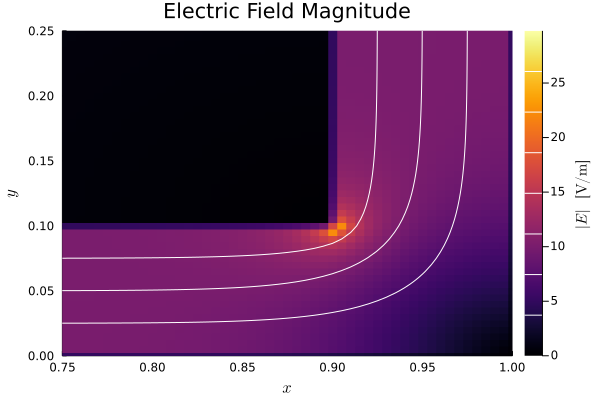

In [6]:
E = sqrt.(Ux.^2 + Uy.^2)
p1 = heatmap(x, y, E, xlabel = L"x", ylabel = L"y", title = "Electric Field Magnitude", colorbar_title = L"|E|\ \ \mathrm{[V/m]}")

# Create contour such that it scales nicely with the colorbar
# Otherwise it will be partially invisible
cntr = maximum(E) * (0.5 * (U / maximum(U)) .+ 0.5)
p1 = contour!(x, y, cntr, color = :white, levels = 7, xlim = (0.75, 1), ylim = (0, 0.25))

In [ ]:
N = 4;
h = 1/N; h2 = h*h;

e = ones(N+1);
A1 = 1/h2 * Tridiagonal(-e[2:end], 2*e, -e[2:end]); 

I = Diagonal(e);

Axx = kron(I, A1);
Ayy = kron(A1, I);

In [ ]:
x  = Vector(0:h:1);
y  = Vector(0:h:1);
Xh = collect(tuple(c,1-r) for r in x, c in y);
xmid = x[1:end-1].+h/2; 
ymid = y[1:end-1].+h/2;
Xmidh = collect(tuple(c,1-r) for r in xmid, c in y)
Ymidh = collect(tuple(c,1-r) for r in x, c in ymid)

c_fun((x,y)) = 1 + 1 * (y < 0.5);
F = zeros(N+1, N+1);
F[3, 3] = 1;
f = reshape(F, (N+1)^2);

c1 = vcat(c_fun.(Xmidh), zeros(1,N+1))
c2 = hcat(c_fun.(Ymidh), zeros(N+1))
C1 = reshape(c1', (N+1)^2);
C2 = reshape(c2', (N+1)^2);

In [ ]:
A = Diagonal(C1) * Axx + Diagonal(C2) * Ayy;

u = A \ f;

In [10]:
Nx = 100;
Ny = 100;

#..compute derived numbers such as 
#..the points on the boundary (Nbnd) and the mesh width (h)
Nxp1 = Nx+1; Nxm1 = Nx-1; hx = 1/Nx; hx2 = hx*hx;
Nyp1 = Ny+1; Nym1 = Ny-1; hy = 1/Ny; hy2 = hy*hy;
Nbnd = 2*(Nx+Ny);

# Construct the 2D mesh
x  = Vector(0:hx:1);
y  = Vector(0:hy:1);
Xh = collect(tuple(c,1-r) for r in x, c in y);

xmid = x[1:end-1].+hx/2; 
ymid = y[1:end-1].+hy/2;
Xmidh = collect(tuple(c,r) for r in xmid, c in y)
Ymidh = collect(tuple(c,r) for r in x, c in ymid)

# Construct the vector fh from the source term
sourceterm((x,y)) = 0;
F = sourceterm.(Xh);
f = zeros(Nxp1 * Nyp1);#reshape(F, Nxp1*Nyp1);

eps0 = 8.85e-12;
c_fun((x,y)) = (1 + 1 * (0.3 < x) * (x < 0.7) * (0.5 < y) * (y < 0.6)) * eps0;
c1 = vcat(zeros(1,Ny+1), c_fun.(Xmidh))
c2 = vcat(zeros(1, Nx+1), c_fun.(Ymidh)')
C1 = reshape(c1, Nxp1*Nyp1);
C2 = reshape(c2, Nxp1*Nyp1);

D1 = C1;
D2 = vcat(C1[2:end], 0);
E1 = C2;
E2 = vcat(C2[Nxp1+1:end], zeros(Nxp1));

D = Tridiagonal(D1[2:end], 0.5 * (D1 + D2), D2[1:end-1])
E = zeros(Nxp1 * Nyp1, Nxp1 * Nyp1)
E[diagind(E, 0)] = 0.5 * (E1 + E2);
E[diagind(E, Nxp1)] = E1[Nxp1+1:end];
E[diagind(E, -Nxp1)] = E2[1:end-Nxp1];

#..construct the mesh indicator matrix IG 
#..this indicator matrix will allow to distinguish interior and boundary nodes 
#..in this indicator matrix the boundary nodes are easy to identify 
#..for interior nodes IG(i,j) = 0 and for the boundary nodes IG(i,j) = 1
#..next construct the indicator vector IGvec by reshaping the indicator matrix IG  
IG = ones(Nxp1,Nyp1);
IG[2:end-1,2:end-1] = zeros(Nxm1,Nym1); 
IGvec = reshape(IG,Nxp1*Nyp1,1); 

#..construct array with linear indices allowing to define interior and boundary nodes 
#..interior: index array with all indices of the interior nodes 
#..boundary: index array with indices of all the boundary nodes 
L = LinearIndices(IGvec); 
interior_cartesian = findall(x->x==0,IGvec); interior = L[interior_cartesian]; 
boundary_cartesian = findall(x->x==1,IGvec); boundary = L[boundary_cartesian]; 

#..construct auxiliary vectors used in the 1D code as well 
ex    = ones(Nxp1);            #..same as in 1D.. 
ey    = ones(Nyp1);            #..same as in 1D.. 
e_bnd = ones(length(boundary)); #..used to handle the boundary nodes 

#..Construct one-dimensional matrix
Ax1 = 1/hx2 * sparse(Tridiagonal(-ex[2:end], 2*ex, -ex[2:end])); 
Ay1 = 1/hy2 * sparse(Tridiagonal(-ey[2:end], 2*ey, -ey[2:end])); 
Ix_int = Diagonal(ex); 
Iy_int = Diagonal(ey); 
I_bnd = Diagonal(e_bnd); 

# Construct single derivative for post-processing
Bx1 = 1/(2*hx) * sparse(Tridiagonal(ex[2:end], 0*ex, -ex[2:end]))
By1 = 1/(2*hy) * sparse(Tridiagonal(ey[2:end], 0*ey, -ey[2:end]))

Bx = kron(Bx1, Iy_int);
By = kron(Ix_int, By1);

#..Construct the 2D matrix using Kronecker products 
Axx = D .* kron(Iy_int, Ax1);
Ayy = E .* kron(Ay1, Ix_int);
A = Axx + Ayy;

#..Handle the boundary conditions in the matrix and the right-hand side vector
A, f = bnd_dirichlet(A, f, 0, boundary, interior);
A, f = bnd_dirichlet(A, f, 1, get_line_y(0.3, 0.7, 0.4, Nx, Ny), interior)
A, f = bnd_dirichlet(A, f, -1, get_line_y(0.3, 0.7, 0.6, Nx, Ny), interior)

#..solve the linear system for the finite difference approximation 
u = A \ f;
U = reshape(u,Nxp1,Nyp1); 

# Post-processing
ux = Bx * u;
uy = By * u;

Ux = reshape(ux, Nxp1, Nyp1);
Uy = reshape(uy, Nxp1, Nyp1);

In [ ]:
E = sqrt.(Ux.^2 + Uy.^2)
p1 = heatmap(x, y, E, xlabel = L"x", ylabel = L"y", title = "Electric Field Magnitude", colorbar_title = L"|E|\ \ \mathrm{[V/m]}")

# Create contour such that it scales nicely with the colorbar
# Otherwise it will be partially invisible
cntr = maximum(E) * (0.5 * (U / maximum(U)) .+ 0.5)
p1 = contour!(x, y, cntr, color = :white, levels = 7)

In [ ]:
Nx = 3;
Ny = 3;

#..compute derived numbers such as 
#..the points on the boundary (Nbnd) and the mesh width (h)
Nxp1 = Nx+1; Nxm1 = Nx-1; hx = 1/Nx; hx2 = hx*hx;
Nyp1 = Ny+1; Nym1 = Ny-1; hy = 1/Ny; hy2 = hy*hy;
Nbnd = 2*(Nx+Ny);

# Construct the 2D mesh
x  = Vector(0:hx:1);
y  = Vector(0:hy:1);
Xh = collect(tuple(c,1-r) for r in x, c in y);

xmid = x[1:end-1].+hx/2; 
ymid = y[1:end-1].+hy/2;
Xmidh = collect(tuple(c,1-r) for r in xmid, c in y)
Ymidh = collect(tuple(c,1-r) for r in x, c in ymid)

c_fun((x,y)) = (1 + 2 * (x < 0.5)) * eps0;
c1 = vcat(zeros(1,Ny+1), c_fun.(Xmidh))
c2 = hcat(zeros(Nx+1), c_fun.(Ymidh))
C1 = reshape(c1, Nxp1*Nyp1);
C2 = reshape(c2, Nxp1*Nyp1);

D1 = C1;
D2 = vcat(C1[2:end], 0);
E1 = C2;
E2 = vcat(C2[Nxp1+1:end], zeros(Nxp1));

D = Tridiagonal(D1[2:end], 0.5 * (D1 + D2), D2[1:end-1])
E = zeros(Nxp1 * Nyp1, Nxp1 * Nyp1)
E[diagind(E, 0)] = 0.5 * (E1 + E2);
E[diagind(E, Nxp1)] = E1[Nxp1+1:end];
E[diagind(E, -Nxp1)] = E2[1:end-Nxp1];